# Sech - Frank's Method

In [3]:
import sympy as sp

from math import exp, log, sqrt
from matplotlib import pyplot as plot
from scipy.optimize import fsolve
from scipy.stats import linregress
from sympy import Symbol, lambdify

import DistExampB as db

from Map import LogRatio
from LocUtil import Grid1, LogGrid1, MinMax, IndexOf, Sub, UnZip

## Set Up

#### constants

In [4]:
nPlot = 201

#### problem

In [5]:
dist = db.ExampB()

#### maping

In [6]:
xSym = Symbol('x')
zSym = Symbol('z')
map_ = LogRatio(xSym, zSym, xRange=(0, 2))
map_.forSym

log(x/(2 - x))

In [7]:
X2Z = map_.Forward
Z2X = map_.Inverse

#### bases

In [8]:
hSym = Symbol('h', positive=True)
zkSym = Symbol('zk', real=True)

In [9]:
baseZ = sp.sqrt(hSym/sp.pi) * 1 / sp.cosh((zSym - zkSym) / sp.sqrt(hSym))
baseZ

sqrt(h)/(sqrt(pi)*cosh((z - zk)/sqrt(h)))

In [10]:
BaseZ = lambdify((zSym,zkSym,hSym), baseZ)

## Constrained Fit to PDF

In [11]:
PdfZ = lambda z: dist.Pdf(map_.Inverse(z))

In [12]:
timeTrunc = 1e-2

In [13]:
zn = fsolve(lambda z: PdfZ(z) - timeTrunc, -3)[0]
zx = fsolve(lambda z: PdfZ(z) - timeTrunc, 6)[0]
zRange = (zn,zx)
zRange

(-3.1026021373001056, 6.393525850353921)

In [20]:
def FrankInterp(F, zRange, nSech, zGrid):
	# parse arguments
	assert(1 < nSech)
	zMin,zMax = zRange
	
	# compute sech points and h
	h = (zMax - zMin) / (nSech - 1)
	
	sechZ = Grid1(*zRange, nSech)
	sechV = tuple(F(z) for z in sechZ)

	# interpolate
	result = []
	for zg in zGrid:
		temp = sum(sv * BaseZ(zg,sz,h) for (sz,sv) in zip(sechZ,sechV))
		result.append(temp)

	return result

In [21]:
distZ = lambda z: dist.Pdf(map_.Inverse(z))

Text(0, 0.5, 'Probability Density')

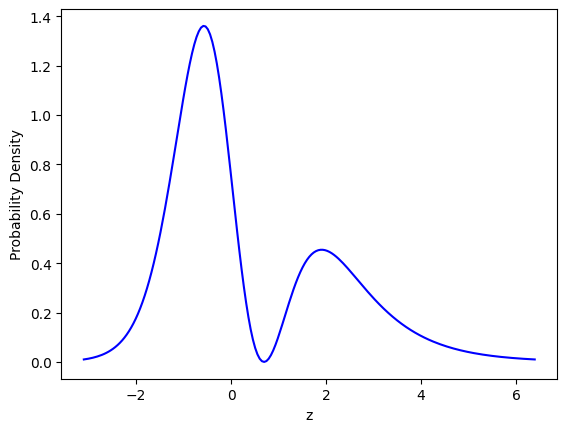

In [22]:
zGrid = Grid1(*zRange, nPlot)
pdf = tuple(distZ(z) for z in zGrid)

plot.plot(zGrid,pdf, c='blue')

plot.xlabel('z')
plot.ylabel('Probability Density')

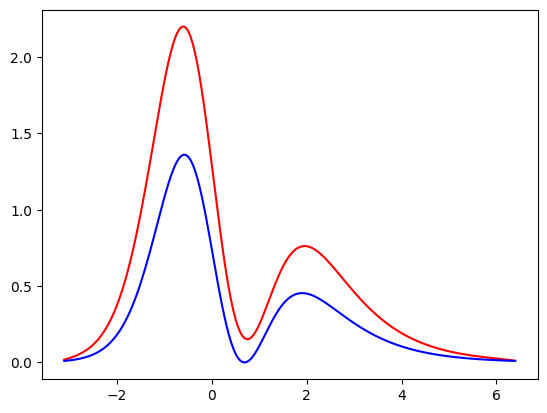

In [29]:
nSech = 320

zGrid = Grid1(*zRange, nPlot)
est = FrankInterp(distZ,zRange,nSech, zGrid)

plot.plot(zGrid,est, c='red')

plot.plot(zGrid, pdf, c='blue')